In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# ============================================================
# 1. DESCARGA DE DATOS
# ============================================================

#inicialización
# Obtener los datos históricos de precios de una acción utilizando yfinance
ACCION= 'PYPL'
FechaIni= '2020-01-01'
FechaFin= '2024-11-21'
data = yf.download(ACCION, start=FechaIni, end=FechaFin, auto_adjust=False)


In [ ]:
# ============================================================
# 2. CALCULAR MACD (12, 26, 9)
# ============================================================

# Calculo macd with standard colors first
# Calculo con precio de cierre
#macd = data.Close.ewm(span=12).mean() - data.Close.ewm(span=26).mean()
# Calculo con precio de cierre ajustado
macd = data['Adj Close'].ewm(span=12).mean() - data['Adj Close'].ewm(span=26).mean()

signal = macd.ewm(span=9).mean()
histogram = macd - signal

# Agregar el MACD al dataframe
data['MACD'] = macd
data['Signal'] = signal
data['Histograma']= histogram

#Elimino los primeros 35 elementos del MACD poniendolos a NaN
#Pensar en hacerlo versátil al cambiar los valores del MACD (12, 26, 9)


cols = ['MACD', 'Signal', 'Histograma']
first35_idx = data.index[:35]   # obtén las 35 primeras etiquetas del índice
data.loc[first35_idx, cols] = np.nan



In [ ]:
# ============================================================
# 3. DETECTAR CRUCES MACD–SIGNAL
# ============================================================

data["Hist_prev"] = data["Histograma"].shift(1)

# Cruce HACIA ABAJO (Hist pasa de positivo → negativo)
data["DownCross"] = (data["Hist_prev"] > 0) & (data["Histograma"] < 0)

# Cruce HACIA ARRIBA (Hist pasa de negativo → positivo)
data["UpCross"] = (data["Hist_prev"] < 0) & (data["Histograma"] > 0)

down_dates = data.index[data["DownCross"]]
up_dates = data.index[data["UpCross"]]

print("Cruces hacia abajo:", len(down_dates))
print("Cruces hacia arriba:", len(up_dates))
#print(down_dates)


df=data

In [12]:
# ============================================================
# 4. CALCULAR RETORNOS A 1–30 DÍAS DESPUÉS DEL CRUCE
# ============================================================

DAYS = 30
returns_down = []

for date in down_dates:
    if date not in df.index:
        continue

    start_price = df.loc[date, "Adj Close"]

    # Para cada día 1..30 después del cruce
    ret_list = []
    for d in range(1, DAYS + 1):
        idx = df.index.get_indexer([date])[0]  # posición del índice
        if idx + d < len(df):
            future_price = df.iloc[idx + d]["Adj Close"]
            ret = (future_price - start_price) / start_price  # retorno en tanto por uno
            ret_list.append(ret)
        else:
            ret_list.append(np.nan)

    returns_down.append(ret_list)

returns_down = pd.DataFrame(returns_down, columns=[f"D{d}" for d in range(1, DAYS + 1)])
returns_down = returns_down.dropna()  # elimina filas incompletas

#Limpiar los elementos del dfataframe para quitar la parte literal.
returns_down = returns_down.applymap(lambda x: float(x.iloc[0]) if hasattr(x, "iloc") else float("nan"))


C:\Users\juanma\AppData\Local\Temp\ipykernel_6488\2104571063.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  returns_down = returns_down.applymap(lambda x: float(x.iloc[0]) if hasattr(x, "iloc") else float("nan"))


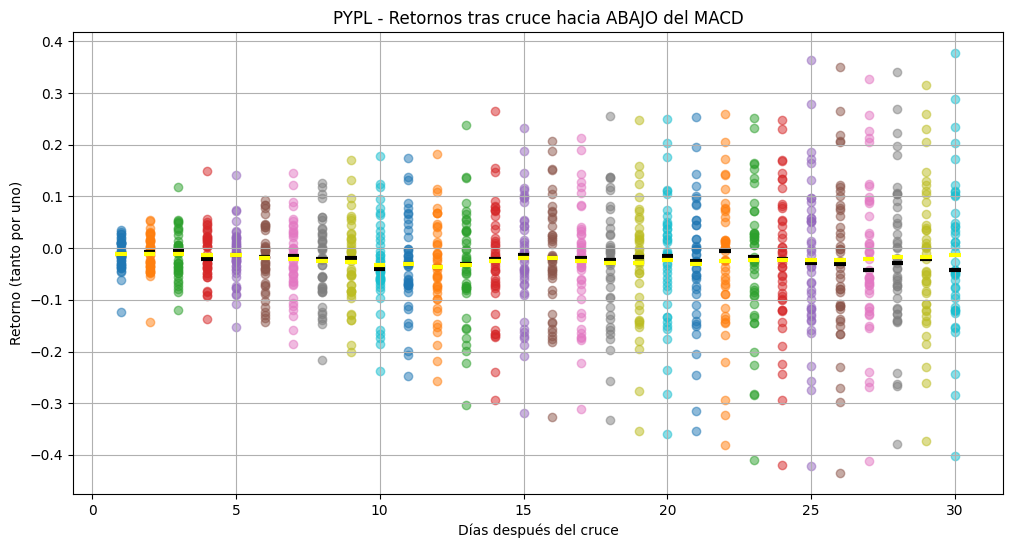

In [13]:

# ============================================================
# 5A. GRÁFICA 1 → NUBE DE PUNTOS (Días vs retorno)
# ============================================================

plt.figure(figsize=(12, 6))

for day in range(1, DAYS + 1):
    plt.scatter([day] * len(returns_down), returns_down[f"D{day}"], alpha=0.5)
    # Línea de mediana
    mediana = returns_down[f"D{day}"].median()
    plt.hlines(mediana, day - 0.2, day + 0.2, linewidth=3, color='black')
    # Línea de medis
    media = returns_down[f"D{day}"].mean()
    plt.hlines(media, day - 0.2, day + 0.2, linewidth=3, color='yellow')



plt.title(f"{ACCION} - Retornos tras cruce hacia ABAJO del MACD")
plt.xlabel("Días después del cruce")
plt.ylabel("Retorno (tanto por uno)")
plt.grid(True)
plt.show()


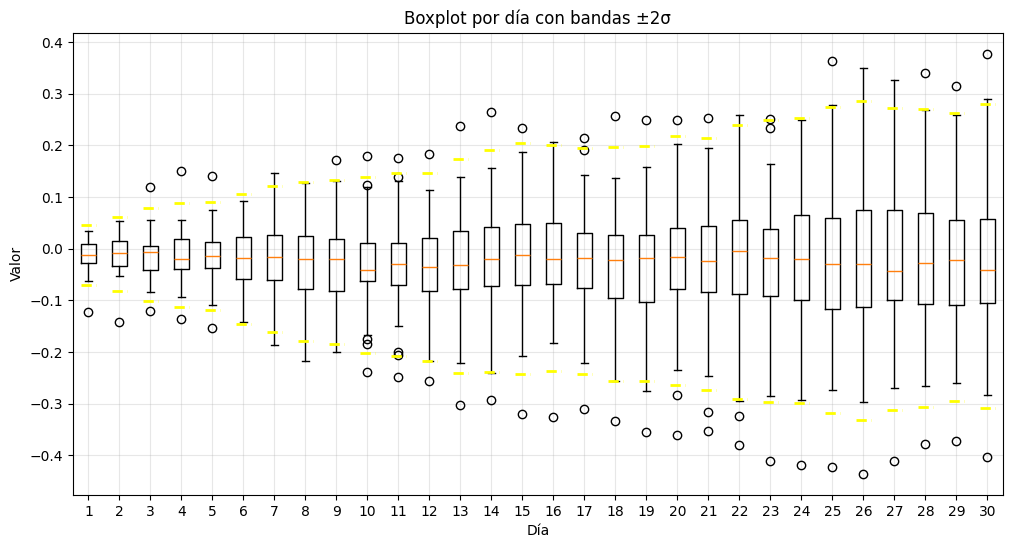

In [14]:
# ============================================================
# 5B. GRÁFICA 2 → BOXPLOT
# ============================================================

plt.figure(figsize=(12,6))

# --- Boxplot ---
plt.boxplot([returns_down[f"D{d}"] for d in range(1, DAYS + 1)], 
            positions=range(1, DAYS + 1))

# --- Bandas ±2σ ---
for day in range(1, DAYS + 1):
    col = returns_down[f"D{day}"]

    mean = col.mean()
    std = col.std()

    upper = mean + 2 * std
    lower = mean - 2 * std

    # Dibujar líneas horizontales de ±2σ
    plt.hlines([upper, lower],             # valores y
               day - 0.25, day + 0.25,     # ancho en x
               colors="yellow",
               linestyles="--",
               linewidth=2)
    
plt.xlabel("Día")
plt.ylabel("Valor")
plt.title("Boxplot por día con bandas ±2σ")
plt.grid(True, alpha=0.3)
plt.show()



In [15]:
# ===========================================================
# Voy a generar una tabla para ver los valores numéricos
# ===========================================================

def stats_with_boxplot_and_sigma(series):
    """Devuelve estadísticas de boxplot + media + desviaciones estándar."""
    
    s = series.dropna().astype(float)

    # Cuartiles e IQR
    Q1 = s.quantile(0.25)
    Q2 = s.quantile(0.50)  # mediana
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1

    # Bigotes
    lower_whisker = s[s >= Q1 - 1.5 * IQR].min()
    upper_whisker = s[s <= Q3 + 1.5 * IQR].max()

    # Outliers
    outliers_lower = s[s < Q1 - 1.5 * IQR].tolist()
    outliers_upper = s[s > Q3 + 1.5 * IQR].tolist()

    # Media y desviaciones estándar
    mean = s.mean()
    std = s.std()

    return {
        "Whisker inferior": lower_whisker,
        "Q1": Q1,
        "Mediana": Q2,
        "Q3": Q3,
        "Whisker superior": upper_whisker,
        "Outliers inferiores": outliers_lower,
        "Outliers superiores": outliers_upper,
        "Media": mean,
        "Std": std,
        "Media - 1*Std": mean - std,
        "Media + 1*Std": mean + std,
        "Media - 2*Std": mean - 2*std,
        "Media + 2*Std": mean + 2*std,
    }

# Construir la tabla completa para todas las columnas D1, D2, ...
stats_table = pd.DataFrame({
    col: stats_with_boxplot_and_sigma(returns_down[col])
    for col in returns_down.columns
}).T

stats_table



,Whisker inferior,Q1,Mediana,Q3,Whisker superior,Outliers inferiores,Outliers superiores,Media,Std,Media - 1*Std,Media + 1*Std,Media - 2*Std,Media + 2*Std
D1,-0.062382,-0.028512,-0.0122,0.009741,0.034927,[-0.1232239846031394],[],-0.011993,0.028819,-0.040812,0.016826,-0.069631,0.045645
D2,-0.053744,-0.034495,-0.0084,0.014738,0.053935,[-0.1427594879873168],[],-0.010793,0.035786,-0.046579,0.024993,-0.082366,0.060779
D3,-0.084182,-0.040719,-0.005848,0.005913,0.05449,[-0.11994526730713],[0.11849003333314623],-0.011403,0.044893,-0.056296,0.03349,-0.101188,0.078382
D4,-0.092857,-0.040011,-0.020215,0.019251,0.056138,[-0.13674857592306836],[0.1495979628585732],-0.01248,0.050548,-0.063028,0.038068,-0.113575,0.088615
D5,-0.108982,-0.037434,-0.013676,0.013143,0.074501,[-0.15273217909809106],[0.14138401917397625],-0.013845,0.052024,-0.065868,0.038179,-0.117892,0.090202
D6,-0.142213,-0.058392,-0.017175,0.022483,0.092511,[],[],-0.020003,0.062525,-0.082529,0.042522,-0.145054,0.105047
D7,-0.185866,-0.060223,-0.015959,0.027232,0.145752,[],[],-0.020112,0.07042,-0.090533,0.050308,-0.160953,0.120728
D8,-0.216556,-0.077563,-0.020538,0.025055,0.126621,[],[],-0.025799,0.076917,-0.102716,0.051118,-0.179633,0.128035
D9,-0.200619,-0.082068,-0.019833,0.018609,0.131026,[],[0.17082999423521686],-0.026357,0.079539,-0.105896,0.053182,-0.185435,0.13272
D10,-0.166176,-0.062508,-0.040424,0.011342,0.119236,"[-0.17440203198545262, -0.23777435928862617, -...","[0.17925315216362134, 0.12338342526610253]",-0.031929,0.084854,-0.116783,0.052925,-0.201637,0.137779
